# Wzy Protein Structural Analysis

In [1]:
wzy_hmms = {}
with open('../wzy_info.txt', 'rt') as f:
    next(f)  # Skip header
    for line in f:
        parts = line.strip().split('\t')
        wzy_hmms['_'.join(parts[0:2]).lower()] = parts[5]

## Generating Wzy 3D Structures

### Prepare AlphaFold3 JSON input files
We use the `generate_af3_json.py` script to generate JSON files as an input to AlphaFold3. This script accepts protein sequences in FASTA format, and generates one JSON file per sequence as per the AF3 documentation.

In [ ]:
%%sh
scripts/generate_af3_json.py fastas/*.faa -o json

### Run AlphaFold3

In [ ]:
%%sh
for i in json/*.json;
    do sbatch -p gpu --gres=gpu:1 -t 20 -n 1 -c 8 \
    --wrap "module load alphafold/3.0.0; run_alphafold.py --json_path=${i} --output_dir=results && mv ${i} completed/";
done

## Comparing Wzy 3D Structures

### Run Foldseek
First, we run Foldseek in the same manner as the ProteinCartography pipeline

In [ ]:
%%sh
foldseek createdb cif/*.cif DB  # Create the Wzy structure database
foldseek search DB DB search_result tmp -a  # Align the sequences to each other and request a backtrace
foldseek aln2tmscore DB DB search_result search_tmscore  # Compute the TM-Score from the alignment backtrace
foldseek createtsv DB DB search_tmscore search_tmscore.tsv  # Convert the scores to tabular format

### Define nearest neighbour and embedding function for later use

In [9]:
from scipy.sparse import coo_matrix
from pynndescent import NNDescent
from umap import UMAP

def get_neighbors_and_embedding(d, n_neighbors: int = 30) -> tuple:
    # Build the NNDescent index and find neighbors
    n_samples, _ = d.shape
    index = NNDescent(d, n_neighbors=n_neighbors)
    index.prepare()
    indices, dists = index.query(d, k=n_neighbors)
    # Initialize UMAP with the precomputed results
    umap = UMAP(n_neighbors=n_neighbors, precomputed_knn=(indices, dists))
    # Create the row indices for the Graph (Sparse Matrix)
    # The column indices are the neighbor indices found by NNDescent, values are the distances
    rows, cols = np.arange(n_samples).repeat(n_neighbors), indices.flatten()
    G = coo_matrix((dists.flatten(), (rows, cols)), shape=(n_samples, n_samples))
    return umap.fit_transform(d), G.maximum(G.T) # Symmetrize the graph, which is common practice.

### Load in TM-Scores

In [6]:
import pandas as pd

nodes, weight = ['query', 'target'], 'tmscore'

df = pd.read_csv(
    '../foldseek/search_tmscore.tsv', sep=r'\s+', header=None, engine='c',
    usecols=[0, 1, 2], names=nodes + [weight]
)

for col in nodes:
    df[col] = df[col].str.rstrip('_model')  # Strip "AF3 suffix"

regex_pattern = r'^abaumannii_(kl|gi1|gi2|ph1).*'
mask = df[nodes[0]].str.contains(regex_pattern, na=False) & df[nodes[1]].str.contains(regex_pattern, na=False)
test_df = df[mask]

/var/folders/19/34hxf43j6n311w4hcqlhddfm54ck3n/T/ipykernel_46133/4173694367.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[nodes[0]].str.contains(regex_pattern, na=False) & df[nodes[1]].str.contains(regex_pattern, na=False)


In [10]:
from sknetwork.clustering import Leiden
import numpy as np

# Create a node to integer mapping from the unique nodes in our filtered data
node2index = {node: i for i, node in enumerate(pd.unique(test_df[nodes].values.ravel("K")))}

adjacency = coo_matrix(
    (test_df[weight].to_numpy(np.float64), (test_df[nodes[0]].map(node2index), test_df[nodes[1]].map(node2index))),
    shape=(len(node2index), len(node2index))
).tocsr()

embedding, graph = get_neighbors_and_embedding(adjacency, n_neighbors=15)

# Perform Leiden clustering on the adjacency matrix
leiden = Leiden()
leiden_clusters = [f"cluster {i+1}" for i in leiden.fit_predict(graph)]

/Users/tsta0015/Programming/Wzy_Analysis/.venv/lib/python3.12/site-packages/umap/umap_.py:2021: UserWarning: precomputed_knn[2] (knn_search_index) is not an NNDescent object: transforming new data with transform will be unavailable.
  warn(
/Users/tsta0015/Programming/Wzy_Analysis/.venv/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


In [15]:
with open('abaumannii_wzy_nndescent_leiden_clusters.tsv', 'wt') as f:
    f.write('\n'.join('\t'.join([k, v, wzy_hmms.get(k, 'not found')]) for k, v in zip(node2index, leiden_clusters)))

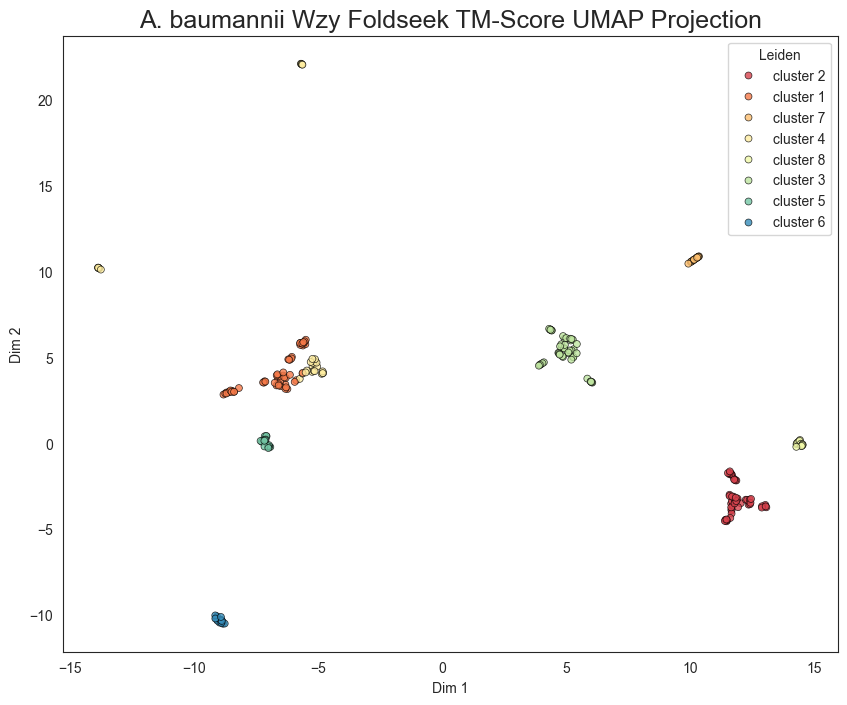

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pd.DataFrame({'Dim 1': embedding[:, 0], 'Dim 2': embedding[:, 1], 'Leiden': leiden_clusters}),
    x='Dim 1', y='Dim 2', hue='Leiden', palette='Spectral', s=25, edgecolor='black', linewidth=0.5, alpha=0.8
)
plt.title('A. baumannii Wzy Foldseek TM-Score UMAP Projection', fontsize=18)
plt.savefig('abaumannii_wzy_nndescent_leiden_clusters.svg', bbox_inches='tight')